In [1]:
import os, sys
import numpy as np
import EMdata
import torch
import itertools
import random, math
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import time

In [2]:
#GPU or CPU
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev) 

In [3]:
#data path
file_path='F:/script/class2vec/real_star_file/10019.star'
datatype=1 #0 is relion 3.1, 1 is relion 3, 2 is cryosparc
block_size=64

file_name=os.path.basename(file_path)
output_path=os.path.dirname(file_path)+'/'+os.path.splitext(file_name)[0]
if os.path.isdir(output_path) is False:
    os.mkdir(output_path)

In [4]:
if datatype<2:
    file_info=EMdata.read_relion(file_path)
    if datatype==0:
        #read data (relion3.1)
        dataset=file_info.getRdata_31()
        optics=file_info.extractoptic()
    else:
        #read relion 3.0
        dataset=file_info.getRdata()
    metadata=dataset[0]
    print(metadata)
    data=dataset[1]
    print(data[0])
    corpus_information=EMdata.process_helical(dataset).extarct_helical_select()
else:
    #read cryosparc
    dataset=np.load(file_path)
    corpus_information=EMdata.process_cryosparc_helical(dataset).extract_helical()
corpus_dic=corpus_information[0]
corpus=list(corpus_dic.values())
corpus_backup=corpus[:]

['_rlnImageName', '_rlnVoltage', '_rlnSphericalAberration', '_rlnAmplitudeContrast', '_rlnDefocusU', '_rlnDefocusV', '_rlnDefocusAngle', '_rlnPhaseShift', '_rlnDetectorPixelSize', '_rlnMagnification', '_rlnClassNumber', '_rlnAngleRot', '_rlnAngleTilt', '_rlnAnglePsi', '_rlnOriginX', '_rlnOriginY', '_rlnHelicalTubeID']
['000001@/net/jiang/scratch/gonzalb/DATA/helical_tool/Extract/job270/empiar-10085-vipAvipB-4.0A-Basler/xb211_Sep29_19.18.43_frames.mrcs', '300.0', '2.0', '0.1', '16453.611328', '16898.582031', '59.427701', '0.0', '5', '48123.2', '32', '-90.0', '0.0', '292.96', '-3.25', '18.85', '1']
finish reading
finish converting
[(32,  1,  0) (32,  2,  1) (32,  3,  2) (27,  4,  3) (30,  5,  4)
 (30,  6,  5) (30,  7,  6) (30,  8,  7) (30,  9,  8) (30, 10,  9)
 (30, 11, 10) (42, 12, 11)]
[(29, 1, 0) (29, 2, 1) (29, 3, 2) (39, 4, 3) (39, 5, 4) (39, 6, 5)
 (39, 7, 6) (39, 8, 7)]
[(27,  9,  0) (37, 10,  1) (37, 11,  2) (37, 12,  3) (37, 13,  4)
 (37, 14,  5) (34, 15,  6) (14, 16,  7) (14, 1

In [5]:
# cryosparc
#corpus_ignore=corpus

In [6]:
corpus_ignore=[]
for i in range(len(corpus)):
    corpus_row=[]
    count=1
    lst=corpus[i]
    for j in range(len(lst)):
        particle=lst[j]
        if j==0:
            count+=particle[1]-1
        if count==int(particle[1]):
            corpus_row.append(str(particle[0]))
            count+=1
        else:
            while 1:
                if count==int(lst[j][1]):
                    corpus_row.append(str(particle[0]))
                    count+=1
                    break
                corpus_row+=['0']
                count+=1               
    corpus_ignore.append(corpus_row)

90


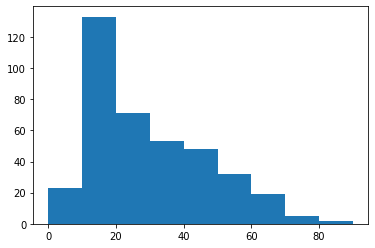

In [7]:
corpus_length_histogram=[]
for i in range(len(corpus_ignore)):
    corpus_length_histogram.append(len(corpus_ignore[i]))
plt.hist(corpus_length_histogram,list(range(0,max(corpus_length_histogram)+10,10)))
#plt.ylim((0,1000))
print(max(corpus_length_histogram))
plt.show()

In [8]:
vocabulary = set(itertools.chain.from_iterable(corpus_ignore))
vocabulary_size = len(vocabulary)
print(vocabulary_size)

33


In [9]:
word_to_index = {w: idx for (idx, w) in enumerate(vocabulary)}
index_to_word = {idx: w for (idx, w) in enumerate(vocabulary)}

In [10]:
from pathlib import Path

from tokenizers import ByteLevelBPETokenizer
if os.path.isdir(output_path+"/corpus") is False:
    os.mkdir(output_path+"/corpus")
paths = [str(x) for x in Path(output_path+"/corpus/").glob("**/*.txt")]

# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer()

# Customize training
tokenizer.train(files=paths, vocab_size=vocabulary_size, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])
if os.path.isdir(output_path+"/tokens") is False:
    os.mkdir(output_path+"/tokens")
if os.path.isdir("./tokens") is False:
    os.mkdir("./tokens")
tokenizer.save_model(output_path+"/tokens")
tokenizer.save_model("./tokens")

['./tokens\\vocab.json', './tokens\\merges.txt']

In [11]:
import json

with open(output_path+'/tokens/vocab.json') as f:
    decode = json.load(f)

In [12]:
encode={value:key for (key, value) in decode.items()}

In [13]:
corpus_code=[]
for i in range(len(corpus_ignore)):
    lst=corpus_ignore[i]
    corpus_row=[]
    for j in range(len(lst)):
        corpus_row.append(encode[word_to_index[lst[j]]+5])
    corpus_code.append(corpus_row)

In [14]:
with open(output_path+"/corpus/helical.txt","w") as f:
    for i in range(len(corpus_code)):
        lst=corpus_code[i]
        for j in range(len(lst)):
            if j==len(lst)-1:
                f.write(lst[j]+'\n')
            else:
                f.write(lst[j])

In [15]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained(output_path+"/tokens", max_len=514)
#tokenizer.encode(encode[word_to_index['0']+5])

In [16]:
print(tokenizer)

In [17]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=50_000,
    max_position_embeddings=128,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)

In [18]:
from transformers import RobertaForMaskedLM

model = RobertaForMaskedLM(config=config)

In [19]:
%%time
from transformers import LineByLineTextDataset

data_import = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path=output_path+"/corpus/helical.txt",
    block_size=block_size,
)

Wall time: 20 ms


In [20]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

In [21]:
print(type(data_import))

<class 'transformers.data.datasets.language_modeling.LineByLineTextDataset'>


In [22]:
from transformers import Trainer, TrainingArguments


trainer = Trainer(
    model=model,
    data_collator=data_collator,
    train_dataset=data_import,
    prediction_loss_only=True,
)

D:\ProgramData\Anaconda3\lib\site-packages\transformers\trainer.py:247: FutureWarning: Passing `prediction_loss_only` as a keyword argument is deprecated and won't be possible in a future version. Use `args.prediction_loss_only` instead.
  FutureWarning,


In [23]:
trainer.train()

TrainOutput(global_step=147, training_loss=6.070824032738095)

In [24]:
trainer.save_model(output_path+"/tokens/")
trainer.save_model("./tokens/")

In [25]:
from transformers import pipeline

feature_extraction = pipeline(
    'feature-extraction',model="./tokens",tokenizer="./tokens")

In [26]:
#print(np.shape(feature_extraction(encode[word_to_index['50']+5])))
#print(np.squeeze(feature_extraction('DGG'))[0]-np.squeeze(feature_extraction('JJ'))[0])
print(''.join(corpus_code[0]))

===!22222224


In [27]:
#def select_random(corpus,number):
    

In [28]:
def cut_corpus(corpus,cut_length):
    new_corpus=[]
    cut_length=cut_length
    print(len(corpus))
    for i in range(len(corpus)):
        lst=corpus[i]
        n=len(lst)
        if n<=cut_length:
            new_corpus.append(lst)
            continue
        if n%cut_length==0:
            cut_amount=int(n/cut_length)
        else:
            cut_amount=int((n-n%cut_length)/cut_length)+1
        for j in range(cut_amount-1):
            new_corpus.append(lst[j*cut_length:(j+1)*cut_length])
        new_corpus.append(lst[(cut_amount-1)*cut_length:])
    print(len(new_corpus))
    return new_corpus
corpus_code_cut=cut_corpus(corpus_code,block_size)

386
398


In [29]:
filament_embeddings=[]
for i in range(len(corpus_code_cut)):
    if i%200==0:
        print(i)
    lst=list(np.squeeze(feature_extraction(''.join(corpus_code_cut[i])))[0])
    filament_embeddings.append(lst)

0
200


In [30]:
print(''.join(corpus_code_cut[3938][12:-5]))
lst=list(np.squeeze(feature_extraction(''.join(corpus_code_cut[3938])[12:23])))
print(len(corpus_code_cut[3938][11:-5]))

IndexError: list index out of range

In [ ]:
print(len(lst))

In [ ]:
len(''.join(corpus_code_cut[77]))

In [31]:
import umap
import sklearn
from sklearn.cluster import KMeans,SpectralClustering,MeanShift, estimate_bandwidth,DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal 
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

In [32]:
filament_embeddings=np.array(filament_embeddings)
mask_1 = np.isfinite(filament_embeddings).all(axis=1)

In [33]:
len(filament_embeddings[mask_1])

398

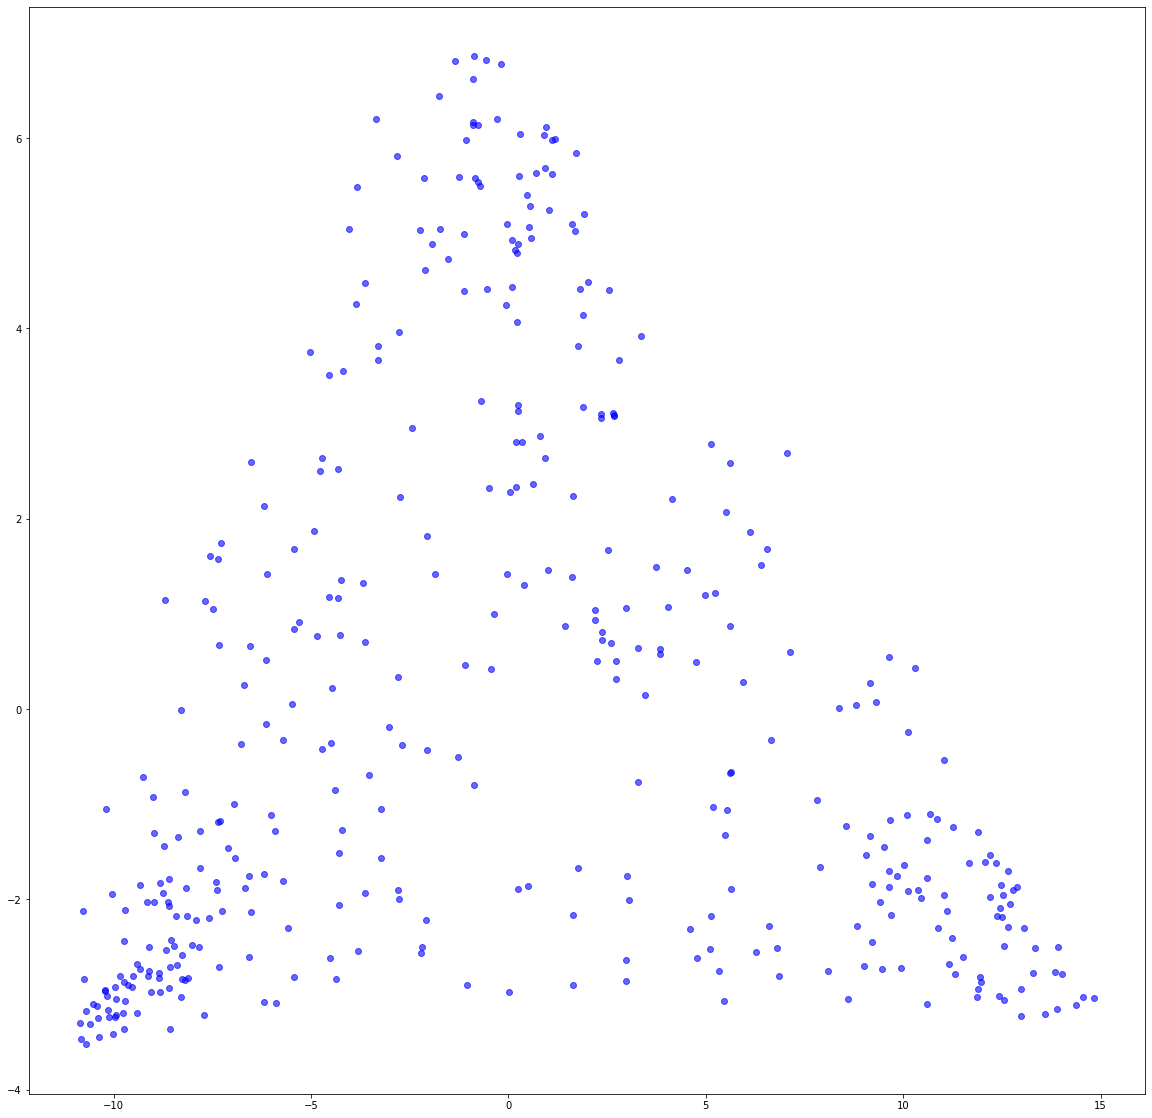

In [35]:
pca_sum = PCA(n_components=2).fit_transform(filament_embeddings)
#cluster_pca = KMeans(n_clusters=3).fit_predict(pca_sum[0:len(corpus)])
pca_sum_hD = PCA(n_components=30).fit_transform(filament_embeddings)

plt.figure(figsize = (20, 20))
plt.scatter(pca_sum[:,0], pca_sum[:,1],alpha=0.6,color='blue')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_bert_pca.png",bbox_inches='tight', pad_inches=0.01)
plt.show()


In [44]:
%%time
n_neighbors=100
min_dist=0.5
#umap_ND=umap.UMAP(n_neighbors=200,min_dist=0.4,n_components=100).fit_transform(filament_embeddings)
reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist)
umap_2D = reducer.fit_transform(filament_embeddings)
umap_ND=umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,n_components=100).fit_transform(filament_embeddings)
print('finish umap')

finish umap
Wall time: 5.59 s


In [45]:
with open(output_path+'/'+'umap_3D_bert.npy', 'wb') as f:
    np.save(f, umap_ND)

In [46]:
filament_cluster_number=2
umap_predict=SpectralClustering(n_clusters=filament_cluster_number).fit_predict(umap_ND)
#umap_predict=DBSCAN(eps=0.41, min_samples=100).fit_predict(umap_2D)+1
#filament_cluster_number=len(np.unique(umap_predict))

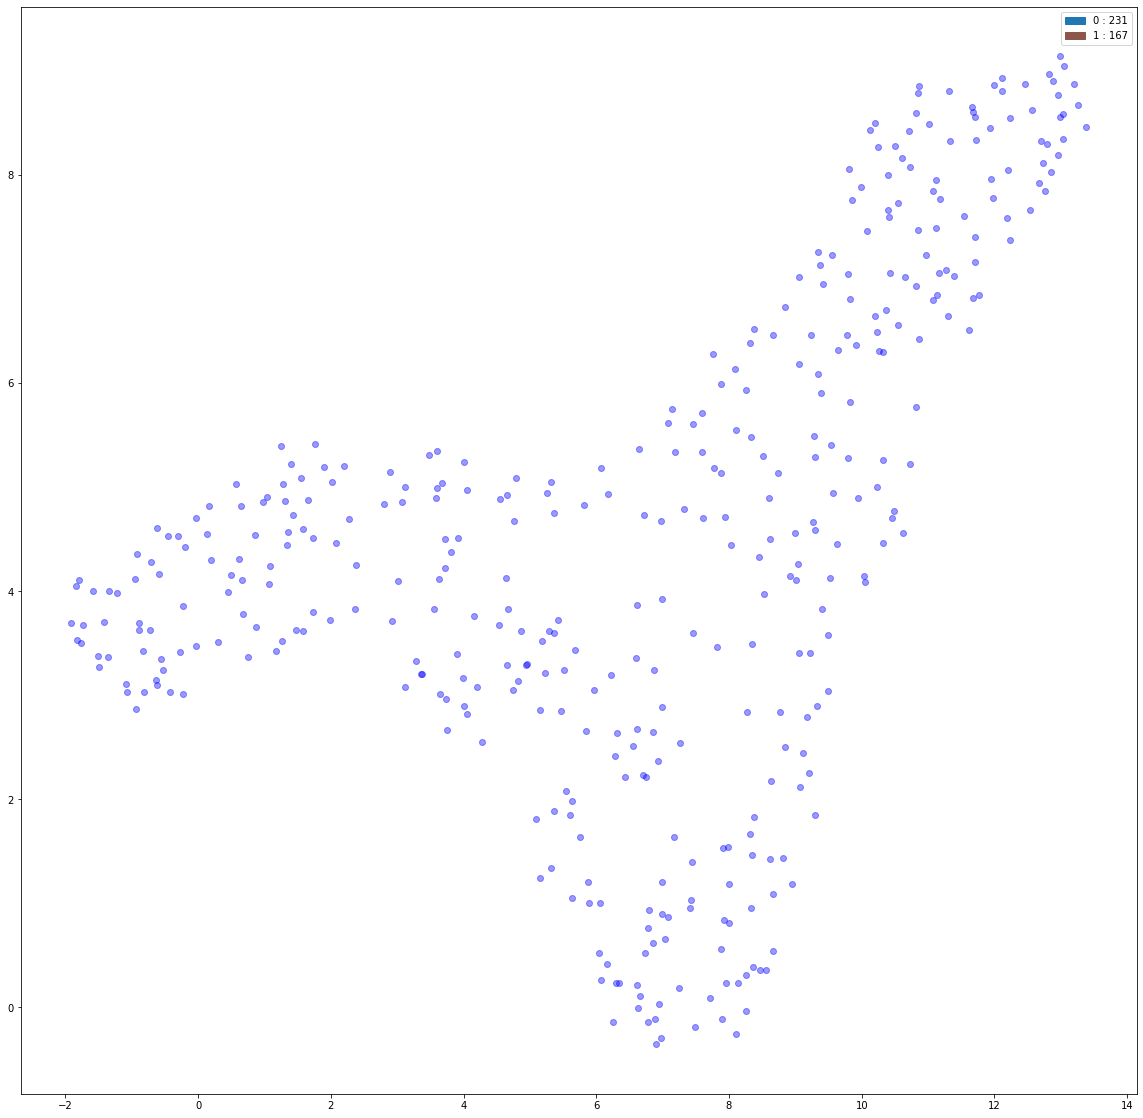

In [47]:
plt.figure(figsize = (20, 20))

for i in range(filament_cluster_number):
    locals()['labels'+str(i)]=mpatches.Patch(color=plt.cm.tab20((i)/filament_cluster_number), 
                                             label=str(i)+' : '+str(np.count_nonzero(umap_predict==i)))
plt.legend(handles=[eval('labels'+str(i)) for i in range(filament_cluster_number)])
#plt.scatter(umap_2D[:,0], umap_2D[:,1],alpha=0.6,c=plt.cm.tab20((umap_predict)/filament_cluster_number))
plt.scatter(umap_2D[:,0], umap_2D[:,1],alpha=0.4,c='blue')
#plt.xlim((-20,20))
#plt.ylim((-10,20))
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_bert_umap_blue.png",bbox_inches='tight', pad_inches=0.01)
#c=plt.cm.tab20((umap_predict+1)/filament_cluster_number)

In [ ]:
for i in range(filament_cluster_number):
    cluster_name='cluster'+str(i)
    cluster_nameID='clusterID'+str(i)
    locals()[cluster_name]=[]
    locals()[cluster_nameID]=[]
data_line=0
cluster_choice=umap_predict
positive_label=[]
for i in range(len(corpus_code_cut)):
    lst=corpus_code_cut[i]
    cluster_number=cluster_choice[i]
    cluster_name='cluster'+str(cluster_number)
    cluster_nameID='clusterID'+str(cluster_number)
    for j in range(len(lst)):
        locals()[cluster_name].append(data[data_line])
        locals()[cluster_nameID].append(data[data_line][0][62:65])
        data_line+=1
    positive_label.append(locals()[cluster_nameID][-1])
positive_label=np.array(positive_label)
labels=list(np.unique(positive_label))
positive_label_new=np.array([float(labels.index(x)) for x in positive_label])
labels_name=['singlet','doublet'] # define the type of filaments 
clustersize=[]
for i in range(filament_cluster_number):
    clustersize.append(len(locals()['cluster'+str(i)]))
print(clustersize)

In [ ]:
data[0][0][62:65]

In [ ]:
plt.figure(figsize = (20, 20))
for i in range(len(labels_name)):
    locals()['true_label'+str(i)]=mpatches.Patch(color=plt.cm.tab20(i/3), label=labels_name[i])
plt.legend(handles=[eval('true_label'+str(i)) for i in range(len(labels))])
print(len(positive_label))
plt.scatter(umap_2D[:,0], umap_2D[:,1],color=plt.cm.tab20(positive_label_new/3),alpha=0.4)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_bert_umap_label.png",bbox_inches='tight', pad_inches=0.01)

In [ ]:
distribution_hist_all=[]
for i in range(filament_cluster_number):
    distribution_hist=[]
    lst=locals()['clusterID'+str(i)]
    for j in range(len(labels)):
        group_percentage=lst.count(labels[j])/len(lst)
        distribution_hist.append(group_percentage)
    distribution_hist_all.append(distribution_hist)
print(distribution_hist_all)
print(len(data),len(cluster0),len(cluster1))

fig, ax = plt.subplots(1,filament_cluster_number,figsize = (5*filament_cluster_number,7))

for i in range(filament_cluster_number):
    ax[i].bar(range(len(labels)),distribution_hist_all[i],tick_label =labels_name)
    particle_number=len(locals()['cluster'+str(i)])
    ax[i].set_title('cluster{} amount: {}'.format(i,particle_number))
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+'distr_new_bert.png')
print('a')

In [ ]:
for i in range(filament_cluster_number):
    cluster_name='cluster'+str(i)
    data_cluster=locals()[cluster_name]
    if datatype==0:
        output=EMdata.output_star(output_path+'/bert_'+file_name,i,data_cluster,metadata)
        output.opticgroup(optics)
        output.writecluster()
    elif datatype==1:
        output=EMdata.output_star(output_path+'/'+file_name,i,data_cluster,metadata)
        output.writemetadata()
        output.writecluster()